## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 1, Task 2: Multilayer Perceptron (MLP)
You will get to know how to build basic fully connected neural network.

In [1]:
# Import modules
import tensorflow as tf
import time
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Basic Layers (15%)

In this part, all the functions will be created from scratch using numpy for better understanding (you will be introduced to built in layers from TensorFlow in the next task). 

### Create basic layer functions

#### Affine layer

Consider an affine layer with depth $M$, for input $X \in R^{N \times D}$, the forward pass (with weights $W \in R^{D \times M}$ and bias $b \in R^M$): 

$$Y = XW + \mathbb{1} b^T \in R^{N \times M}$$

<font color="red"><strong>TODO</strong></font>: Complete 

1. The following equations and the output shapes. 
2. The functions `affine_forward`, `affine_backward` in **./utils/layer_funcs.py**. 

Replace the $\color{cyan}{[eq.]}$ inside the equations with your own answer. 

<font color="red"><strong>NOTE</strong></font>: If you're not familiar with LaTeX-style eqautions, see https://latex-tutorial.com/tutorials/amsmath/ for tutorials. 

<font color="red"><strong>Hint</strong></font>: Arrange the terms so that the shape of the gradient matches the shape of the differentiation variable. 

Assume the upstream gradient from the final output $Z$ w.r.t the layer output $Y$ is $\nabla_Y Z = g \in R^{N \times M}$, show the backward pass[1]: 

$$
\nabla_X Z = {{[gW^T]}} \in R^{\color{cyan}{[eq.]}}, \quad
\nabla_W Z = {{[X^Tg]}} \in R^{\color{cyan}{[eq.]}}, \quad
\nabla_b Z = {{[g^T\mathbb{1}]}} \in R^{\color{cyan}{[eq.]}}
$$

[1] http://cs231n.stanford.edu/handouts/linear-backprop.pdf

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [8]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function: H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## check your implementation using the tf.gradients_function()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check, dw_check, db_check = dx_tf.numpy(), dw_tf.numpy(), db_tf.numpy()

## Print validation results
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


#### ReLU layer

Since $ReLU(\cdot)$ is an element-wise mapping, consider the function admits a scaler input $x$, the forward pass: 

$$y = \max (x, 0)$$

<font color="red"><strong>TODO</strong></font>: Complete 

1. The following equation. 
2. The functions `relu_forward`, `relu_backward` in **./utils/layer_funcs.py**.

Replace the $\color{cyan}{[eq.]}$ inside the equations with your own answer. 

Assume the upstream gradient from the final output $Z$ w.r.t the layer output $y$ is $\nabla_y Z = g$, show the backward pass: 

$$
\nabla_x Z = \begin{cases}
{{g}} & \text{if } x > 0 \\
{{0}} & \text{else}
\end{cases}
$$

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [9]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)

## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    out_tf = tf.nn.relu(x_tf)
    grad_gt = tape.gradient(out_tf, x_tf)

out_check = out_tf.numpy()
dx_check = grad_gt.numpy()
## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


#### Softmax cross-entropy layer

Recall the softmax function $\sigma (\cdot): R^K \to \Delta_K$ and the cross entropy $H (\cdot): \Delta_K \times \Delta_K \to R_+$: 

$$
\sigma (s) = \frac{e^s}{\sum_k e^{s_i}}, \quad
H(p, q) = -p^T \log q
$$

Assume the predictions $X \in R^{N \times K}$ ($x_i \in X$ is the logit over all classes in $R^K$ for the $i$-th data sample, $\sigma_i = \sigma (x_i) \in \Delta_K$) and the ground truth $P \in R^{N \times K}$ ($p_i \in P$ is the one-hot encoding of the ground truth class in $R^K$), the softmax cross entropy loss: 

$$L = \frac{1}{N} \sum_i L_i = \frac{1}{N} \sum_i H(p_i, \sigma_i)$$

<font color="red"><strong>TODO</strong></font>: Complete 

1. The following equations and the output shapes. 
2. The functions `softmax_loss` in **./utils/layer_funcs.py**. 

Replace the $\color{cyan}{[eq.]}$ inside the equations with your own answer. 

<font color="red"><strong>Hint</strong></font>: 
Refer to the notations and derivation in [***Task 1 Part 2***](./task1-basic_classifiers.ipynb#Part-2:-Softmax-Classifier) where we worked on $\nabla_W L$ (please pay attention to the changes). 

Show the backward pass. You can do this in two steps: 

- Using $p_i \in R^K$ and $\sigma_i \in R^K$, show the gradient of $L_i$ w.r.t $x_i$: 

$$\nabla_{x_i} L_i = {\color{cyan}{[eq.]}} \in R^{\color{cyan}{[eq.]}}$$

- Using $P = (p_1, \dots, p_N) \in R^{N \times K}$ and $\sigma = (\sigma_1, \dots, \sigma_N) \in R^{N \times K}$, show the gradient of $L$ w.r.t $X$: 

$$\nabla_X L = {\color{cyan}{[eq.]}} \in R^{\color{cyan}{[eq.]}}$$

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [10]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100, 10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

## check by tf.GradientTape.gradients()

x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')

with tf.GradientTape() as tape:
    tape.watch(x_tf)
    loss_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=x_tf, labels=tf.one_hot(y_tf, 10)))
    dx_tf = tape.gradient(loss_tf, x_tf)

loss_check = loss_tf.numpy()
dx_check = dx_tf.numpy()
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

We are going to implement an affine layer, and then a dense layer on top of that. 

* input >> AffineLayer >> output

```
    class AffineLayer:
        __init__:
            params - weights and bias
            cache - intermeidate results for back propagation
            gradients - gradients of the parameters for optimization
        feedforward: forward pass
        backward: backward pass
        update_layer: update layer parameters
```

* input >> AffineLayer >> ReLU >> output

```
    class DenseLayer:
        __init__:
            affine - an affine layer
            activation: activation function
        feedforward: forward pass
        backward: backward pass
        update_layer: update layer parameters
```

<font color="red"><strong>TODO</strong></font>: Complete function `AffineLayer` in **./utils/layer_utils.py**

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [11]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=X_train.shape[1], output_dim=100)
w, b = test_affine.params['W'], test_affine.params['b']

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients['W'], test_affine.gradients['b']

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<font color="red"><strong>TODO</strong></font>: Complete function `DenseLayer` in **./utils/layer_utils.py**

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [13]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=X_train.shape[1], output_dim=100)
w, b = test_dense.params['W'], test_dense.params['b']

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients['W'], test_dense.gradients['b']

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = dense_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: Two Layer Network (15%)

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like 

* input >> DenseLayer >> AffineLayer >> softmax loss >> output

```
    class TwoLayerNet:
        __init__: 
            - layers: a dense layer and an affine layer
        forward: forward pass
        loss: cross entropy loss and gradients
        step: a single step update of all weights and bias by SGD.
        predict: output result (classification accuracy) based on input data
        save_model: return the parameters of the network
        update_model: update model weights (by calling layer.update_layer)
```

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD

$$w \gets w - \alpha \nabla_w L$$

* SGD with momentum

$$v \gets \beta v + \alpha \nabla_w L,\quad w \gets w - v$$

where $\alpha$ is the learning rate (step size) and $\beta$ is the momentum. 

<font color="red"><strong>TODO</strong></font>: Complete class `TwoLayerNet` in **./utils/classifiers/twolayernet.py**

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [14]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=100, num_classes=20, reg=1e-4)
W1, b1 = model.layer1.params['W'], model.layer1.params['b']
W2, b2 = model.layer2.params['W'], model.layer2.params['b']
## Feedforward
y_score = model.forward(X_dev)
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(y_score, y_dev)

## Check loss by tensorflow
x_tf = tf.Variable(X_dev, dtype=tf.float32)
y_tf = tf.Variable(y_dev, dtype=tf.uint8)

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf))
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=h2_tf, labels=tf.one_hot(y_tf, 20))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss 

loss_check=loss_tf.numpy()
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [15]:
from train_funcs import train, test

#### Start training
We have provide you the `train` function in **./utils/train_func.py**

In [16]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=400, num_classes=20, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(
    model, X_train, y_train, X_val, y_val, num_epoch=num_epoch, batch_size=batch_size, 
    learning_rate=lr, verbose=verbose
)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.8751420105152623
10000/49000 loss: 2.7081579087011707
15000/49000 loss: 2.7723468032650476
20000/49000 loss: 2.354329763889147
25000/49000 loss: 2.1977398995086754
30000/49000 loss: 2.0992474917026676
35000/49000 loss: 1.7951702240847647
40000/49000 loss: 1.462415857778022
45000/49000 loss: 1.5982584117341878
epoch 1: valid acc = 0.542, new learning rate = 0.000475
5000/49000 loss: 1.2399854067034857
10000/49000 loss: 1.1244056565138496
15000/49000 loss: 1.069378799896336
20000/49000 loss: 1.081794285783357
25000/49000 loss: 1.0647088938490965
30000/49000 loss: 1.0400577482427207
35000/49000 loss: 1.016126767085666
40000/49000 loss: 0.9546804097164022
45000/49000 loss: 0.8745495751345441
epoch 2: valid acc = 0.699, new learning rate = 0.00045125
5000/49000 loss: 0.9126926898556199
10000/49000 loss: 0.8468229280724838
15000/49000 loss: 0.82519400076307
20000/49000 loss: 0.7561932736885341
25000/49000 loss: 0.7300932971077566
30000/49

0.8294

<font color="red"><strong>TODO</strong></font>: Plot training and validation accuracy history of each epoch. Remember to add a legend. 

In [ ]:
## TODO: plot the accuracy history

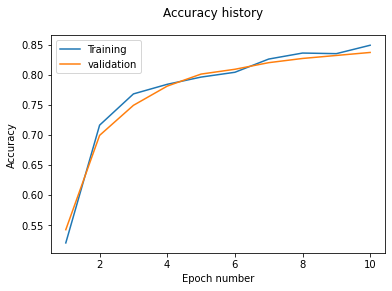

In [17]:
x_axis = [*range(1, num_epoch+1, 1)]
# Accuracy history
plt.plot(x_axis, train_acc_hist, label='Training')
plt.plot(x_axis, val_acc_hist, label='validation')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('Accuracy history')
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [18]:
from utils.display_funcs import visualize_pics

num of feature vectors: 400


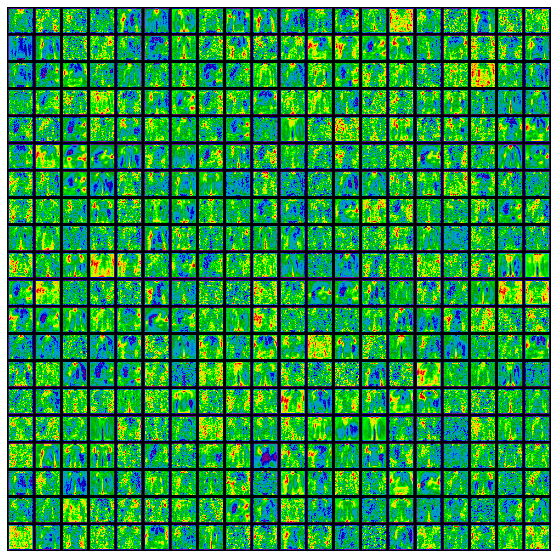

In [19]:
weights = model.layer1.params['W']
pics = weights.reshape(1, X_train_raw.shape[1], X_train_raw.shape[2], -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics, cmap='nipy_spectral')

### Get test accuracy greater than 80%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 80%. If your accuracy is lower, for each 1% lower than 80%, you will lose 1 point (There are totally 10 points for this part).

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.

<font color="red"><strong>TODO</strong></font>: See below

In [20]:
from utils.classifiers.twolayernet import TwoLayerNet
# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to the code below, using your parameter specs:
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=400, num_classes=20, reg=1e-4, weight_scale=1e-3)
num_epoch = 30
batch_size = 500
lr = 5e-4
verbose = True


train_acc_hist, val_acc_hist = train(
    model, X_train, y_train, X_val, y_val, num_epoch=num_epoch, batch_size=batch_size, 
    learning_rate=lr, verbose=verbose
)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.773640737473292
10000/49000 loss: 2.7338947750097824
15000/49000 loss: 2.530014493795448
20000/49000 loss: 2.4254133552531094
25000/49000 loss: 2.430199412841373
30000/49000 loss: 2.099442343468411
35000/49000 loss: 1.8905883645415673
40000/49000 loss: 1.7283184310134652
45000/49000 loss: 1.568426322092415
epoch 1: valid acc = 0.525, new learning rate = 0.000475
5000/49000 loss: 1.2620999438100156
10000/49000 loss: 1.1158976426072642
15000/49000 loss: 1.181453759459045
20000/49000 loss: 1.1193485107354963
25000/49000 loss: 1.014314848669482
30000/49000 loss: 0.9842068266399546
35000/49000 loss: 0.917737733853277
40000/49000 loss: 0.8655445005978624
45000/49000 loss: 0.9170580812107058
epoch 2: valid acc = 0.693, new learning rate = 0.00045125
5000/49000 loss: 0.9081071114203655
10000/49000 loss: 0.7947292636115225
15000/49000 loss: 0.7767392248410422
20000/49000 loss: 0.7606150103385759
25000/49000 loss: 0.6450762907749495
30000/490

0.8499

#### <font color="red"><strong>TODO</strong></font>: Show your best result, including accuracy and weights of the first layer

In [ ]:
## TODO: plot training and validation accuracy

In [ ]:
## TODO: Visualize weights

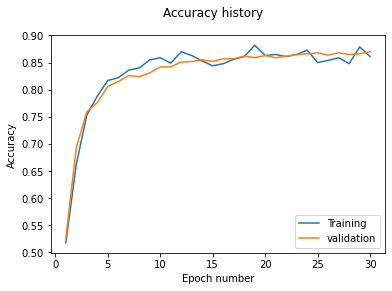

In [21]:
x_axis = [*range(1, num_epoch+1, 1)]
# Accuracy history
plt.plot(x_axis, train_acc_hist, label='Training')
plt.plot(x_axis, val_acc_hist, label='validation')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('Accuracy history')
plt.show()

num of feature vectors: 400


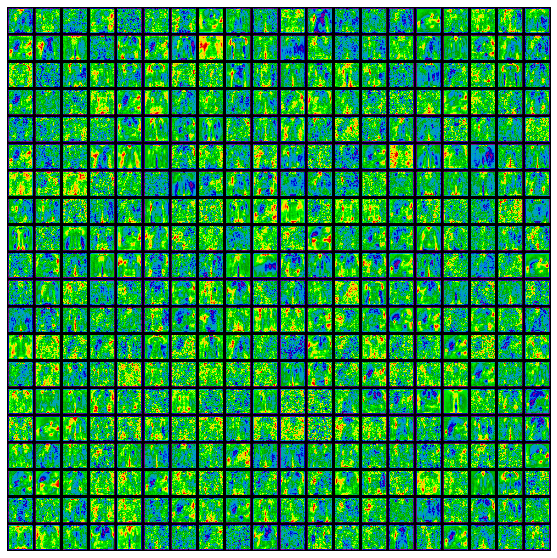

In [22]:
weights = model.layer1.params['W']
pics = weights.reshape(1, X_train_raw.shape[1], X_train_raw.shape[2], -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics, cmap='nipy_spectral')

### Save your best model in a dictionary 

In [23]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [24]:
## Load your model
with open("./save_models/best_model.pkl", "rb") as input_file:
   loaded_model = pickle.load(input_file)

model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=300, num_classes=20)
model.update_model(loaded_model)

## Part 3: Multilayer Network (10%)

Complete the class **MLP** in **./utils/classifiers/mlp.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<font color="red"><strong>TODO</strong></font>: Complete the class `MLP` in **./utils/classifiers/mlp.py**

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [26]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200, 100], num_classes=20, reg=0.5, weight_scale=1e-3)

num_epoch = 10
batch_size = 128
lr = 5e-3
verbose = False
train_acc_hist, val_acc_hist = train(
    model, X_train, y_train, X_val, y_val, 
    num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, 
    optim='SGD', momentum=0.9, verbose=verbose
)
test(model, X_test, y_test)

number of batches for training: 382
epoch 1: valid acc = 0.821, new learning rate = 0.00475
epoch 2: valid acc = 0.851, new learning rate = 0.0045125
epoch 3: valid acc = 0.871, new learning rate = 0.004286875
epoch 4: valid acc = 0.874, new learning rate = 0.00407253125
epoch 5: valid acc = 0.863, new learning rate = 0.0038689046874999995
epoch 6: valid acc = 0.88, new learning rate = 0.003675459453124999
epoch 7: valid acc = 0.883, new learning rate = 0.003491686480468749
epoch 8: valid acc = 0.869, new learning rate = 0.0033171021564453113
epoch 9: valid acc = 0.876, new learning rate = 0.0031512470486230455
epoch 10: valid acc = 0.868, new learning rate = 0.002993684696191893
test acc: 0.8744


0.8744

<font color="red"><strong>TODO</strong></font>: Plot training and validation accuracy history of each epoch

In [ ]:
#TODO: plot training and validation accuracy

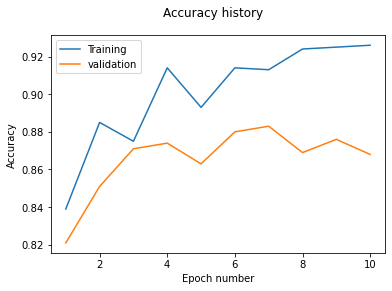

In [27]:
x_axis = [*range(1, num_epoch+1, 1)]
# Accuracy history
plt.plot(x_axis, train_acc_hist, label='Training')
plt.plot(x_axis, val_acc_hist, label='validation')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('Accuracy history')
plt.show()